In [1]:
from os import path

# Third-party
import astropy.coordinates as coord
from astropy.table import Table, vstack
from astropy.io import fits
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from pyia import GaiaData

import gala.coordinates as gc
import gala.dynamics as gd
from scipy.stats import binned_statistic

Load data:

In [2]:
g = GaiaData('../data/gd1-with-masks.fits')
g = g[g.phi2 > -8*u.deg]

In [3]:
pm_mask = g.pm_mask
cmd_mask = g.gi_cmd_mask
stream_mask = pm_mask & cmd_mask

In [4]:
(stream_mask).sum()

5287

In [5]:
phi1 = g.phi1
phi2 = g.phi2
pm1 = g.pm_phi1_cosphi2
pm2 = g.pm_phi2

---

## Stream track

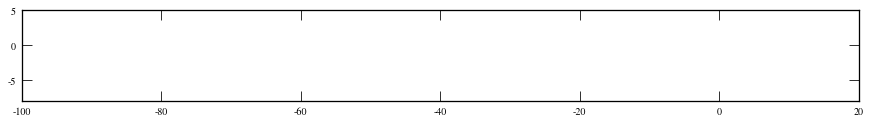

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(15, 2))

ax.plot(phi1[stream_mask],
        phi2[stream_mask], 
        linestyle='none', alpha=0.4, c='k')

ax.set_xlim(-100, 20)
ax.set_ylim(-8, 5)

ax.set_aspect('equal')

### First, compute the stream track:

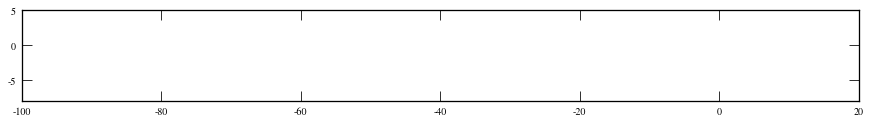

In [7]:
phi2_wide_mask = stream_mask & (phi2 < 2.*u.deg) & (phi2 > -5.*u.deg)

fig, ax = plt.subplots(1, 1, figsize=(15, 2))

ax.plot(phi1[phi2_wide_mask],
        phi2[phi2_wide_mask], 
        linestyle='none', alpha=0.4, c='k')

ax.set_xlim(-100, 20)
ax.set_ylim(-8, 5)

ax.set_aspect('equal')

In [11]:
 bin_size = 4 # deg
# bin_l = np.arange(-80, (0-bin_size)+1, 2.)
# # bin_size = 8 # deg
# # bin_l = np.arange(-85, (10-bin_size)+1, 4)
# bin_r = bin_l + bin_size
# bin_c = 0.5 * (bin_l+bin_r)
# len(bin_r)

In [12]:
bins_nonoverlap = np.arange(-90, (20-bin_size)+1, bin_size)
cen_phi1 = 0.5 * (bins_nonoverlap[:-1] + bins_nonoverlap[1:])

# median track
phi2_median, be, bn = binned_statistic((phi1[phi2_wide_mask]), 
                                        phi2[phi2_wide_mask], 
                                        statistic='median', bins=bins_nonoverlap)
phi2_sum, be = np.histogram((phi1[phi2_wide_mask]), 
                            bins=bins_nonoverlap)
phi2_median_err = np.abs(phi2_median) / np.sqrt(phi2_sum)

In [13]:
phi2_median[0] = -3.1
phi2_median[1] = -2.8
phi2_median[2] = -2.55
phi2_median[3] = -1.9
phi2_median[4] = -1.7
phi2_median[5] = -1.5
phi2_median[6] = -1.

phi2_median[-9] = -0.1

phi2_median[-2] = -2.1
phi2_median[-1] = -2.4

In [14]:
deg = 4
ptrack = np.polyfit(cen_phi1, phi2_median, deg, w=1 / np.sqrt(phi2_sum))

polytrack = np.poly1d(ptrack)
phi1_ = np.linspace(-100, 20, 100)
phi2_ = polytrack(phi1_)

np.save('../output/polytrack.npy', ptrack.tolist())

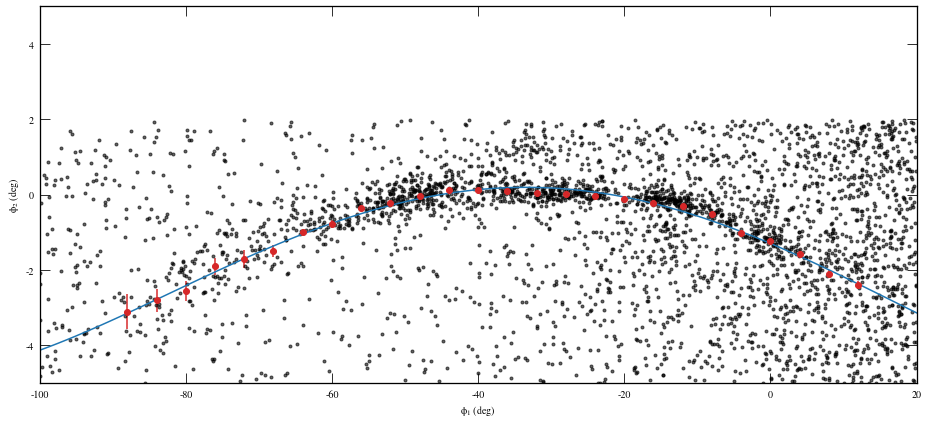

In [15]:
plt.figure(figsize=(13, 6))
plt.plot(phi1[phi2_wide_mask], 
         phi2[phi2_wide_mask], 
         'ko', ms=3, alpha=0.6, rasterized=True)
# plt.gca().set_aspect('equal')

plt.errorbar(cen_phi1, phi2_median, yerr=phi2_median_err, fmt='o', color='tab:red')
plt.plot(phi1_, phi2_, '-', color='tab:blue')

plt.xlabel('$\phi_1$ (deg)')
plt.ylabel('$\phi_2$ (deg)')
plt.xlim(-100, 20)
plt.ylim(-5, 5)

plt.tight_layout()

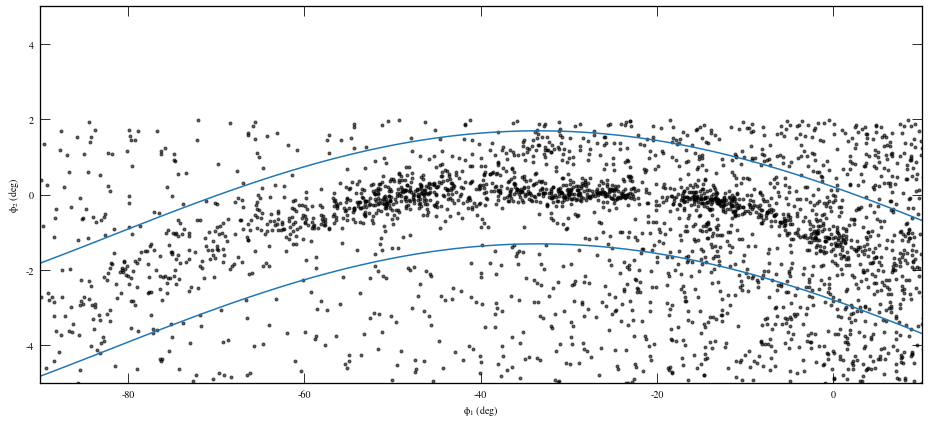

In [16]:
delta_phi2 = 1.5

plt.figure(figsize=(13, 6))
plt.plot(phi1[phi2_wide_mask], 
         phi2[phi2_wide_mask], 
         'ko', ms=3, alpha=0.6, rasterized=True)
# plt.gca().set_aspect('equal')

plt.plot(phi1_, phi2_ + delta_phi2, '-', color='tab:blue')
plt.plot(phi1_, phi2_ - delta_phi2, '-', color='tab:blue')

plt.xlabel('$\phi_1$ (deg)')
plt.ylabel('$\phi_2$ (deg)')
plt.xlim(-90, 10)
plt.ylim(-5, 5)

plt.tight_layout()

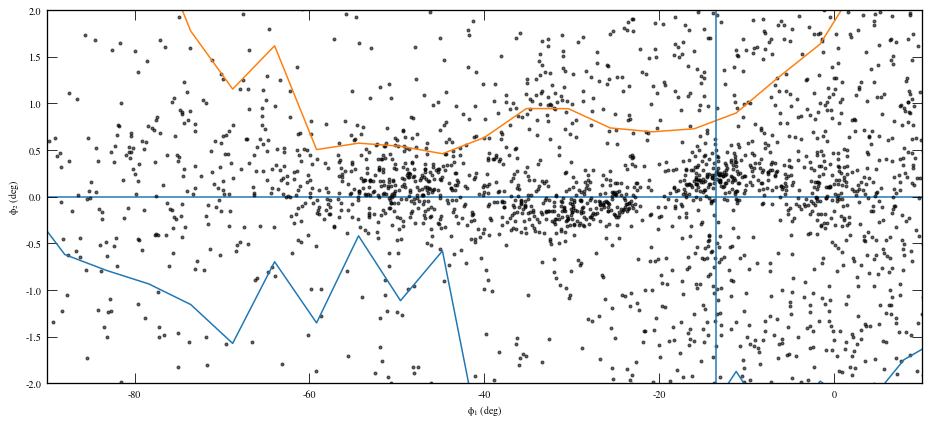

In [17]:
plt.figure(figsize=(13,6))

_phi1 = phi1[phi2_wide_mask]
dphi2 = phi2[phi2_wide_mask].value - polytrack(_phi1)

res15 = binned_statistic(_phi1, dphi2, bins=25, 
                         statistic=lambda x: np.percentile(x, 15))
res85 = binned_statistic(_phi1, dphi2, bins=25,
                         statistic=lambda x: np.percentile(x, 85))

plt.plot(_phi1, dphi2,
         'ko', ms=3, alpha=0.6, rasterized=True)

plt.plot(0.5 * (res15.bin_edges[:-1] + res15.bin_edges[1:]), 
         res15.statistic, marker='')
plt.plot(0.5 * (res85.bin_edges[:-1] + res85.bin_edges[1:]), 
         res85.statistic, marker='')

# plt.gca().set_aspect('equal')

plt.xlabel('$\phi_1$ (deg)')
plt.ylabel('$\phi_2$ (deg)')
plt.xlim(-90, 10)
plt.ylim(-2, 2)

plt.axhline(0., zorder=-10, color='tab:blue')
plt.axvline(-13.5)
plt.tight_layout()

In [ ]:
def mad_std(x):
    """Median absolute deviation"""
    return 1.5 * np.median(np.abs(np.median(x)-x))

In [ ]:
off_phi2 = 2.5

In [ ]:
bin_size = 4 # deg
bin_l = np.arange(-90, (10-bin_size)+1, 2.)
bin_r = bin_l + bin_size
bins_phi1 = 0.5 * (bin_l+bin_r)

Nbins = len(bin_l)
n = np.zeros(Nbins)
n_back = np.zeros(Nbins)
w = np.zeros(Nbins)*u.deg
rmed_phi2 = np.zeros(Nbins)*u.deg
rmed_pmphi1 = np.zeros(Nbins)*u.mas/u.yr
rmed_pmphi2 = np.zeros(Nbins)*u.mas/u.yr
rmed_pmphi1_err = np.zeros(Nbins)*u.mas/u.yr
rmed_pmphi2_err = np.zeros(Nbins)*u.mas/u.yr

phi2_poly = polytrack(phi1[pm_mask & cmd_mask].value)

_phi1 = phi1[pm_mask & cmd_mask].value
for i, l, r in zip(range(Nbins), bin_l, bin_r):
    sel_bin = (_phi1 > l) & (_phi1 <= r)
    sel_stream = (np.abs(phi2[pm_mask & cmd_mask].to(u.deg).value - phi2_poly) < delta_phi2)
    sel_back = ((np.abs(phi2[pm_mask & cmd_mask].to(u.deg).value - phi2_poly - off_phi2)<delta_phi2) |
                (np.abs(phi2[pm_mask & cmd_mask].to(u.deg).value - phi2_poly + off_phi2)<delta_phi2))
    selection = sel_bin & sel_stream
    
    n[i] = np.sum(selection)
    n_back[i] = np.sum(sel_bin & sel_back) * 0.5
    
    rmed_phi2[i] = np.nanmedian(phi2[pm_mask & cmd_mask][selection])
    w[i] = mad_std(phi2[pm_mask & cmd_mask][selection])
    
    rmed_pmphi1[i] = np.nanmedian(pm1[pm_mask & cmd_mask][selection])
    rmed_pmphi1_err[i] = mad_std(pm1[pm_mask & cmd_mask][selection])
    
    rmed_pmphi2[i] = np.nanmedian(pm2[pm_mask & cmd_mask][selection])
    rmed_pmphi2_err[i] = mad_std(pm2[pm_mask & cmd_mask][selection])
    
density = (n-n_back)/(2*delta_phi2*bin_size)

In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(8,10), sharex=True)

ax = axes[0]
ax.plot(phi1[phi2_wide_mask], 
        phi2[phi2_wide_mask], 
        'ko', ms=2, alpha=0.6, rasterized=True)

ax.plot(phi1_, phi2_+delta_phi2, '-', color='tab:blue')
ax.plot(phi1_, phi2_-delta_phi2, '-', color='tab:blue')
ax.text(-83, 1.5, 'filtered data', ha='left', va='top', 
        bbox=dict(facecolor='w', alpha=1), fontsize=16)
ax.set_ylabel('$\phi_2$\n[deg]')
ax.set_ylim(-4, 2)

ax.text(8, 1.5, '(a)', ha='right', va='top', 
        bbox=dict(facecolor='w', alpha=1), fontsize=16)

ax = axes[1]
ax.plot(bins_phi1, density, '-', label='data')
ax.fill_between(bins_phi1, density*(1-1/np.sqrt(n)), density*(1+1/np.sqrt(n)), 
                color='tab:blue', alpha=0.3)
ax.axhline(0, zorder=-10, alpha=0.2)
ax.set_ylabel('surface\ndensity\n[deg$^{-2}$]')

ax.text(8, 18, '(c)', ha='right', va='top', 
        bbox=dict(facecolor='w', alpha=1), fontsize=16)

ax = axes[2]
ax.plot(bins_phi1, rmed_pmphi1, '-')
ax.fill_between(bins_phi1, rmed_pmphi1-rmed_pmphi1_err, rmed_pmphi1+rmed_pmphi1_err, 
                color='tab:blue', alpha=0.3)

ax.set_ylabel('$\mu_{\phi_1}$\n[mas yr$^{-1}$]')

ax.text(8, -13.5, '(d)', ha='right', va='bottom', 
        bbox=dict(facecolor='w', alpha=1), fontsize=16)

ax = axes[3]
ax.plot(bins_phi1, rmed_pmphi2, '-')
ax.fill_between(bins_phi1, rmed_pmphi2-rmed_pmphi2_err, rmed_pmphi2+rmed_pmphi2_err, 
                color='tab:blue', alpha=0.3)

ax.set_xlabel('$\phi_1$ [deg]')
ax.set_ylabel('$\mu_{\phi_2}$\n[mas yr$^{-1}$]')

ax.text(8, -4.5, '(e)', ha='right', va='bottom', 
        bbox=dict(facecolor='w', alpha=1), fontsize=16)

axes[0].set_xlim(-85, 10)

fig.tight_layout()

In [ ]:
# Write out the track properties:

# output table w track observables
ttrack = Table([bins_phi1, n, n_back, density, rmed_phi2, w, rmed_pmphi1, rmed_pmphi1_err, rmed_pmphi2, rmed_pmphi2_err],
              names=('phi1', 'n', 'n_back', 'density', 'phi2', 'w', 'pm_phi1_cosphi2', 'pm_phi1_cosphi2_error', 
                     'pm_phi2', 'pm_phi2_error'))
# skip 0th row because nan
ttrack.write('../output/stream_track.fits', overwrite=True)

In [ ]:
len(ttrack)

In [ ]:
len(Table.read('../data/track.fits'))